# 时间序列分析第九次作业
作业主题：利率期限结构  
数据：美国五年期国债收益率2022-11-16至今数据  
步骤：数据导入-数据清洗-数据差分-数据平稳性随机性检验-hp滤波分解数据-趋势采用holt指数平滑-周期采用快速傅立叶变换谱分析-模型预测  

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入
AKShare借口调取 2022-11-16 至今 中美国债收益率数据（利率期限结构），仅保留美国五年国债收益率这个时间序列数据分析

In [4]:
import akshare as ak
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing

## 数据导入
# AKShare借口调取 2022-11-16 至今 中美国债收益率数据（利率期限结构）
bond_zh_us_rate_df = ak.bond_zh_us_rate(start_date="20221116")
print('原始数据表：', bond_zh_us_rate_df)

# 仅保留美国五年国债收益率这个时间序列数据分析
original_data = bond_zh_us_rate_df[['美国国债收益率5年']]
print('美国五年期国债收益率：', original_data)

原始数据表：              日期  中国国债收益率2年  中国国债收益率5年  中国国债收益率10年  中国国债收益率30年  中国国债收益率10年-2年  \
0    2022-11-16     2.3839     2.6824      2.8329      3.2309         0.4490   
1    2022-11-17     2.3583     2.6379      2.8026      3.2109         0.4443   
2    2022-11-18     2.3490     2.6281      2.8250      3.2209         0.4760   
3    2022-11-21     2.3409     2.6195      2.8180      3.2086         0.4771   
4    2022-11-22     2.3299     2.6158      2.8276      3.2161         0.4977   
..          ...        ...        ...         ...         ...            ...   
533  2024-11-11     1.4131     1.7409      2.0920      2.2575         0.6789   
534  2024-11-12     1.4081     1.7130      2.0729      2.2360         0.6648   
535  2024-11-13     1.4209     1.7186      2.0876      2.2600         0.6667   
536  2024-11-14     1.4146     1.7065      2.0808      2.2610         0.6662   
537  2024-11-15     1.4034     1.7099      2.0948      2.2825         0.6914   

     中国GDP年增率  美国国债收益率2年  美国国债收益

## 二、数据清洗
### 2.1 缺失值的处理
采用线性插值填充
### 2.2 异常值的处理
Z得分检测异常值，认为在$3\sigma$外为异常值；
使用Winsorize处理，大于$3\sigma$的值使用$3\sigma$处对应的值替代，小于$3\sigma$的值使用$-3\sigma$处对应的值替代

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


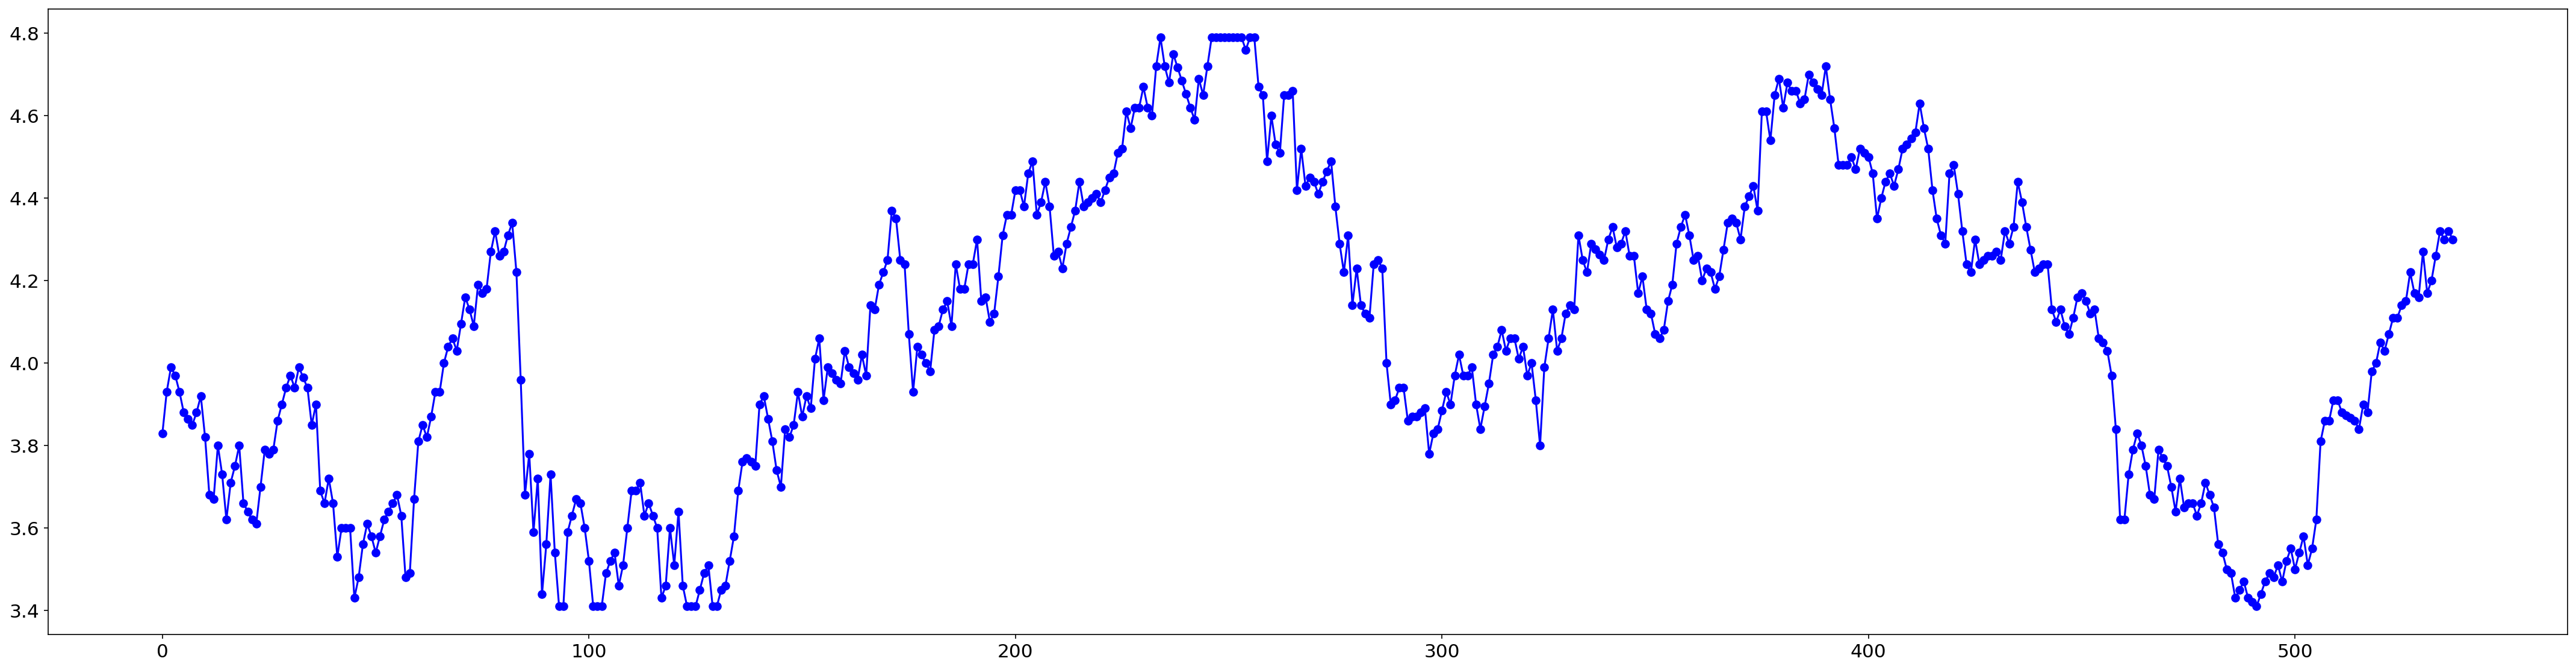

In [5]:
## 数据清洗
# 缺失值处理：使用线性插值填充
data = original_data.interpolate()

# Z得分检测异常值
mean_value = data.mean()
std_value = data.std()
z_scores = (data - mean_value)/std_value

# 异常值处理：Winsorize处理，用边界值替代
column_data = data.values
winsorized_data = winsorize(column_data, limits=[0.02, 0.02])
data = winsorized_data.flatten()

# 绘制序列图做平稳性检验
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='美国五年国债收益率清洗后的序列图.png')

## 三、数据差分与平稳性检验
### 3.1 对数变换
数据尺度太大，先对数变换缩小尺度

In [6]:
## 数据差分与平稳性检验
data = np.log(data)

### 3.2 原始数据的平稳性检验
#### 3.2.1 ADF检验
原假设$$H0:序列非平稳$$
备择假设$$H1:序列平稳$$

In [7]:
# 数据做 ADF 检验
result_ADF = adfuller(data , autolag='AIC')
print(f' ADF 检验统计量：{result_ADF[0]}')
print(f'p 值：{result_ADF[1]}')
print(f'临界值（1%）：{result_ADF[4]["1%"]}')
print(f'临界值（5%）：{result_ADF[4]["5%"]}')
print(f'临界值（10%）：{result_ADF[4]["10%"]}')

if result_ADF[1] < 0.05:
    print('ADF检验下数据是平稳的。')
else:
    print('ADF检验下数据不是平稳的。')

 ADF 检验统计量：-2.307996423566422
p 值：0.16940193457666064
临界值（1%）：-3.4425861905056556
临界值（5%）：-2.8669372502674824
临界值（10%）：-2.5696445454608505
ADF检验下数据不是平稳的。


#### 3.2.2 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [8]:
# 数据做 PP 检验
pp = PhillipsPerron(data)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下数据是非平稳数据。")

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.383
P-value                         0.147
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
不拒绝原假设，PP检验下数据是非平稳数据。


### 3.3 一阶差分和平稳性检验
#### 3.3.1 一阶差分

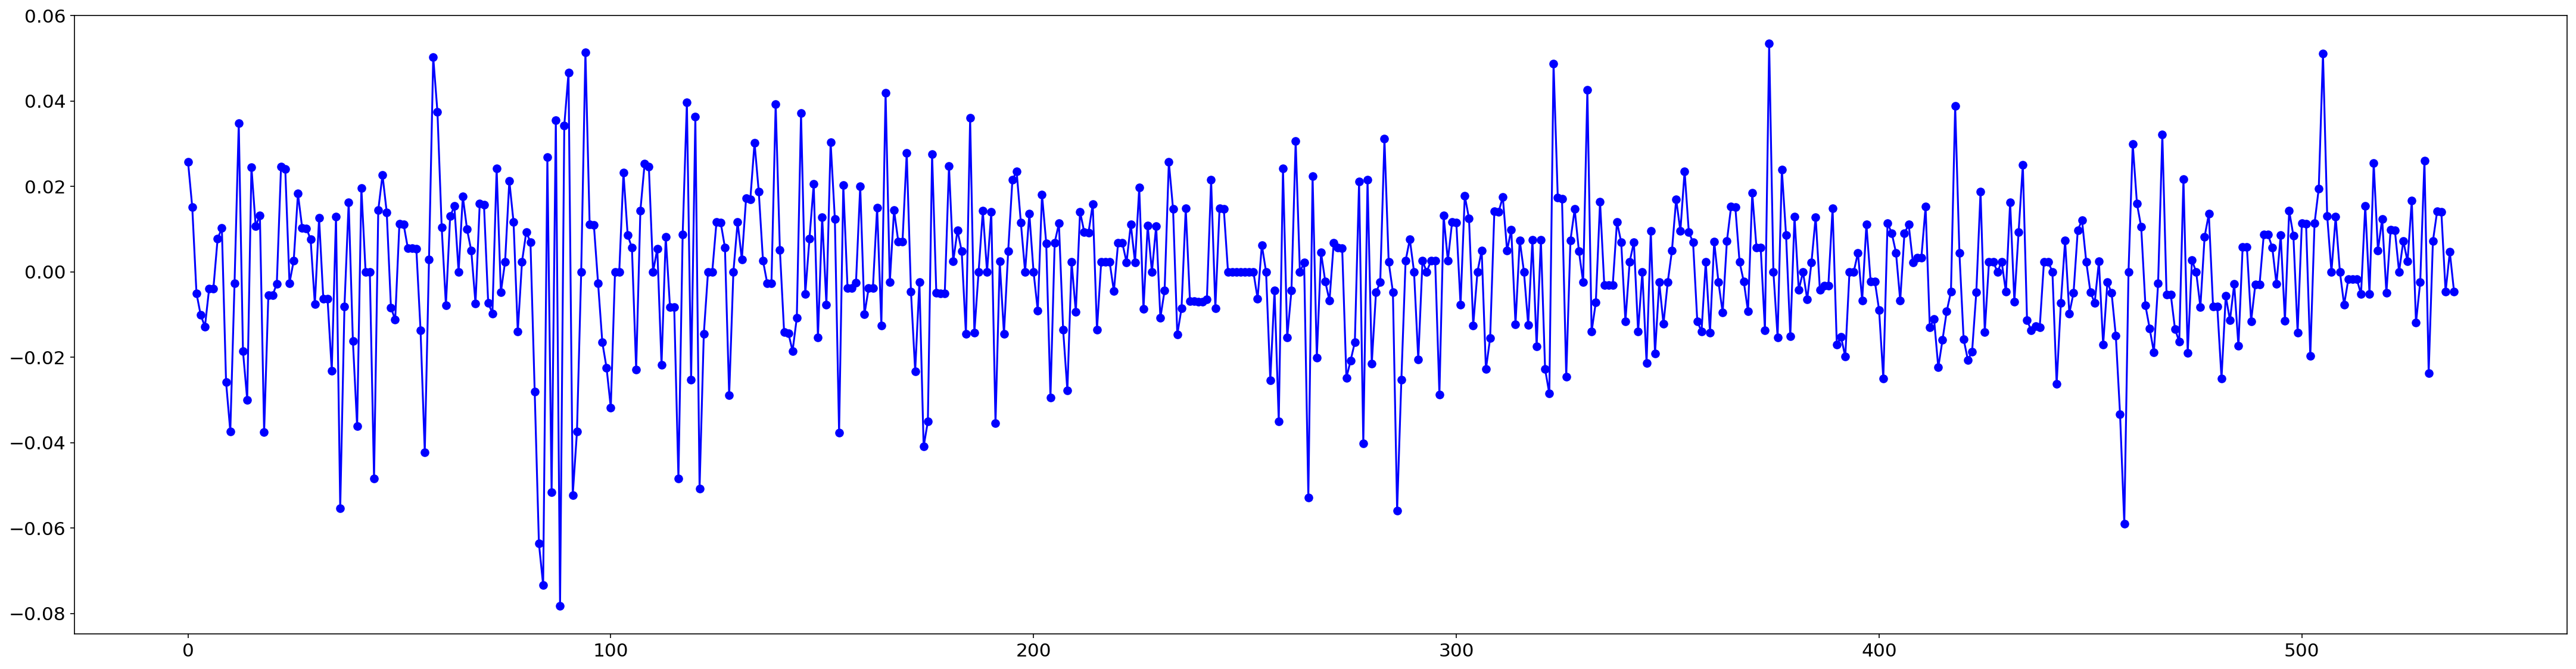

In [9]:
# 一阶差分
first_order_diff = np.diff(data)

# 绘制一阶差分后的序列图
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='一阶差分后的的序列图.png')

#### 3.3.2 ADF检验
原假设$$H0:序列非平稳$$
备择假设$$H1:序列平稳$$

In [10]:
# 对一阶差分后的数据做 ADF 检验
result_first_order = adfuller(first_order_diff , autolag='AIC')
print(f'一阶差分后 ADF 检验统计量：{result_first_order[0]}')
print(f'p 值：{result_first_order[1]}')
print(f'临界值（1%）：{result_first_order[4]["1%"]}')
print(f'临界值（5%）：{result_first_order[4]["5%"]}')
print(f'临界值（10%）：{result_first_order[4]["10%"]}')

if result_first_order[1] < 0.05:
    print('一阶差分数据是平稳的。')
else:
    print('一阶差分数据不是平稳的。')

一阶差分后 ADF 检验统计量：-23.407836696976457
p 值：0.0
临界值（1%）：-3.442609129942274
临界值（5%）：-2.866947348175723
临界值（10%）：-2.569649926626197
一阶差分数据是平稳的。


#### 3.3.3 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [11]:
# 对一阶差分后的数据做 PP 检验
pp = PhillipsPerron(first_order_diff)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下一节差分后的数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下一节差分后的数据是非平稳数据。")

     Phillips-Perron Test (Z-tau)    
Test Statistic                -23.434
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
拒绝原假设，PP检验下一节差分后的数据是平稳数据。


## 四、纯随机检验
已经判断差分后的序列为平稳性数据，进一步判断是否为白噪声数据，采用LB检验。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，p值小于0.05，拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [12]:
## 纯随机检验
LB = acorr_ljungbox(data, lags=[1,5,10,20,50,100,200], boxpierce=True, return_df=True)
print(LB)

          lb_stat      lb_pvalue       bp_stat      bp_pvalue
1      518.958052  7.132338e-115    516.074952  3.023391e-114
5     2415.077748   0.000000e+00   2393.032427   0.000000e+00
10    4415.414328   0.000000e+00   4356.627848   0.000000e+00
20    7317.597051   0.000000e+00   7166.966755   0.000000e+00
50   10250.242256   0.000000e+00   9924.161804   0.000000e+00
100  10490.468916   0.000000e+00  10127.092147   0.000000e+00
200  11159.842407   0.000000e+00  10634.250302   0.000000e+00


## 五、HP滤波分解数据

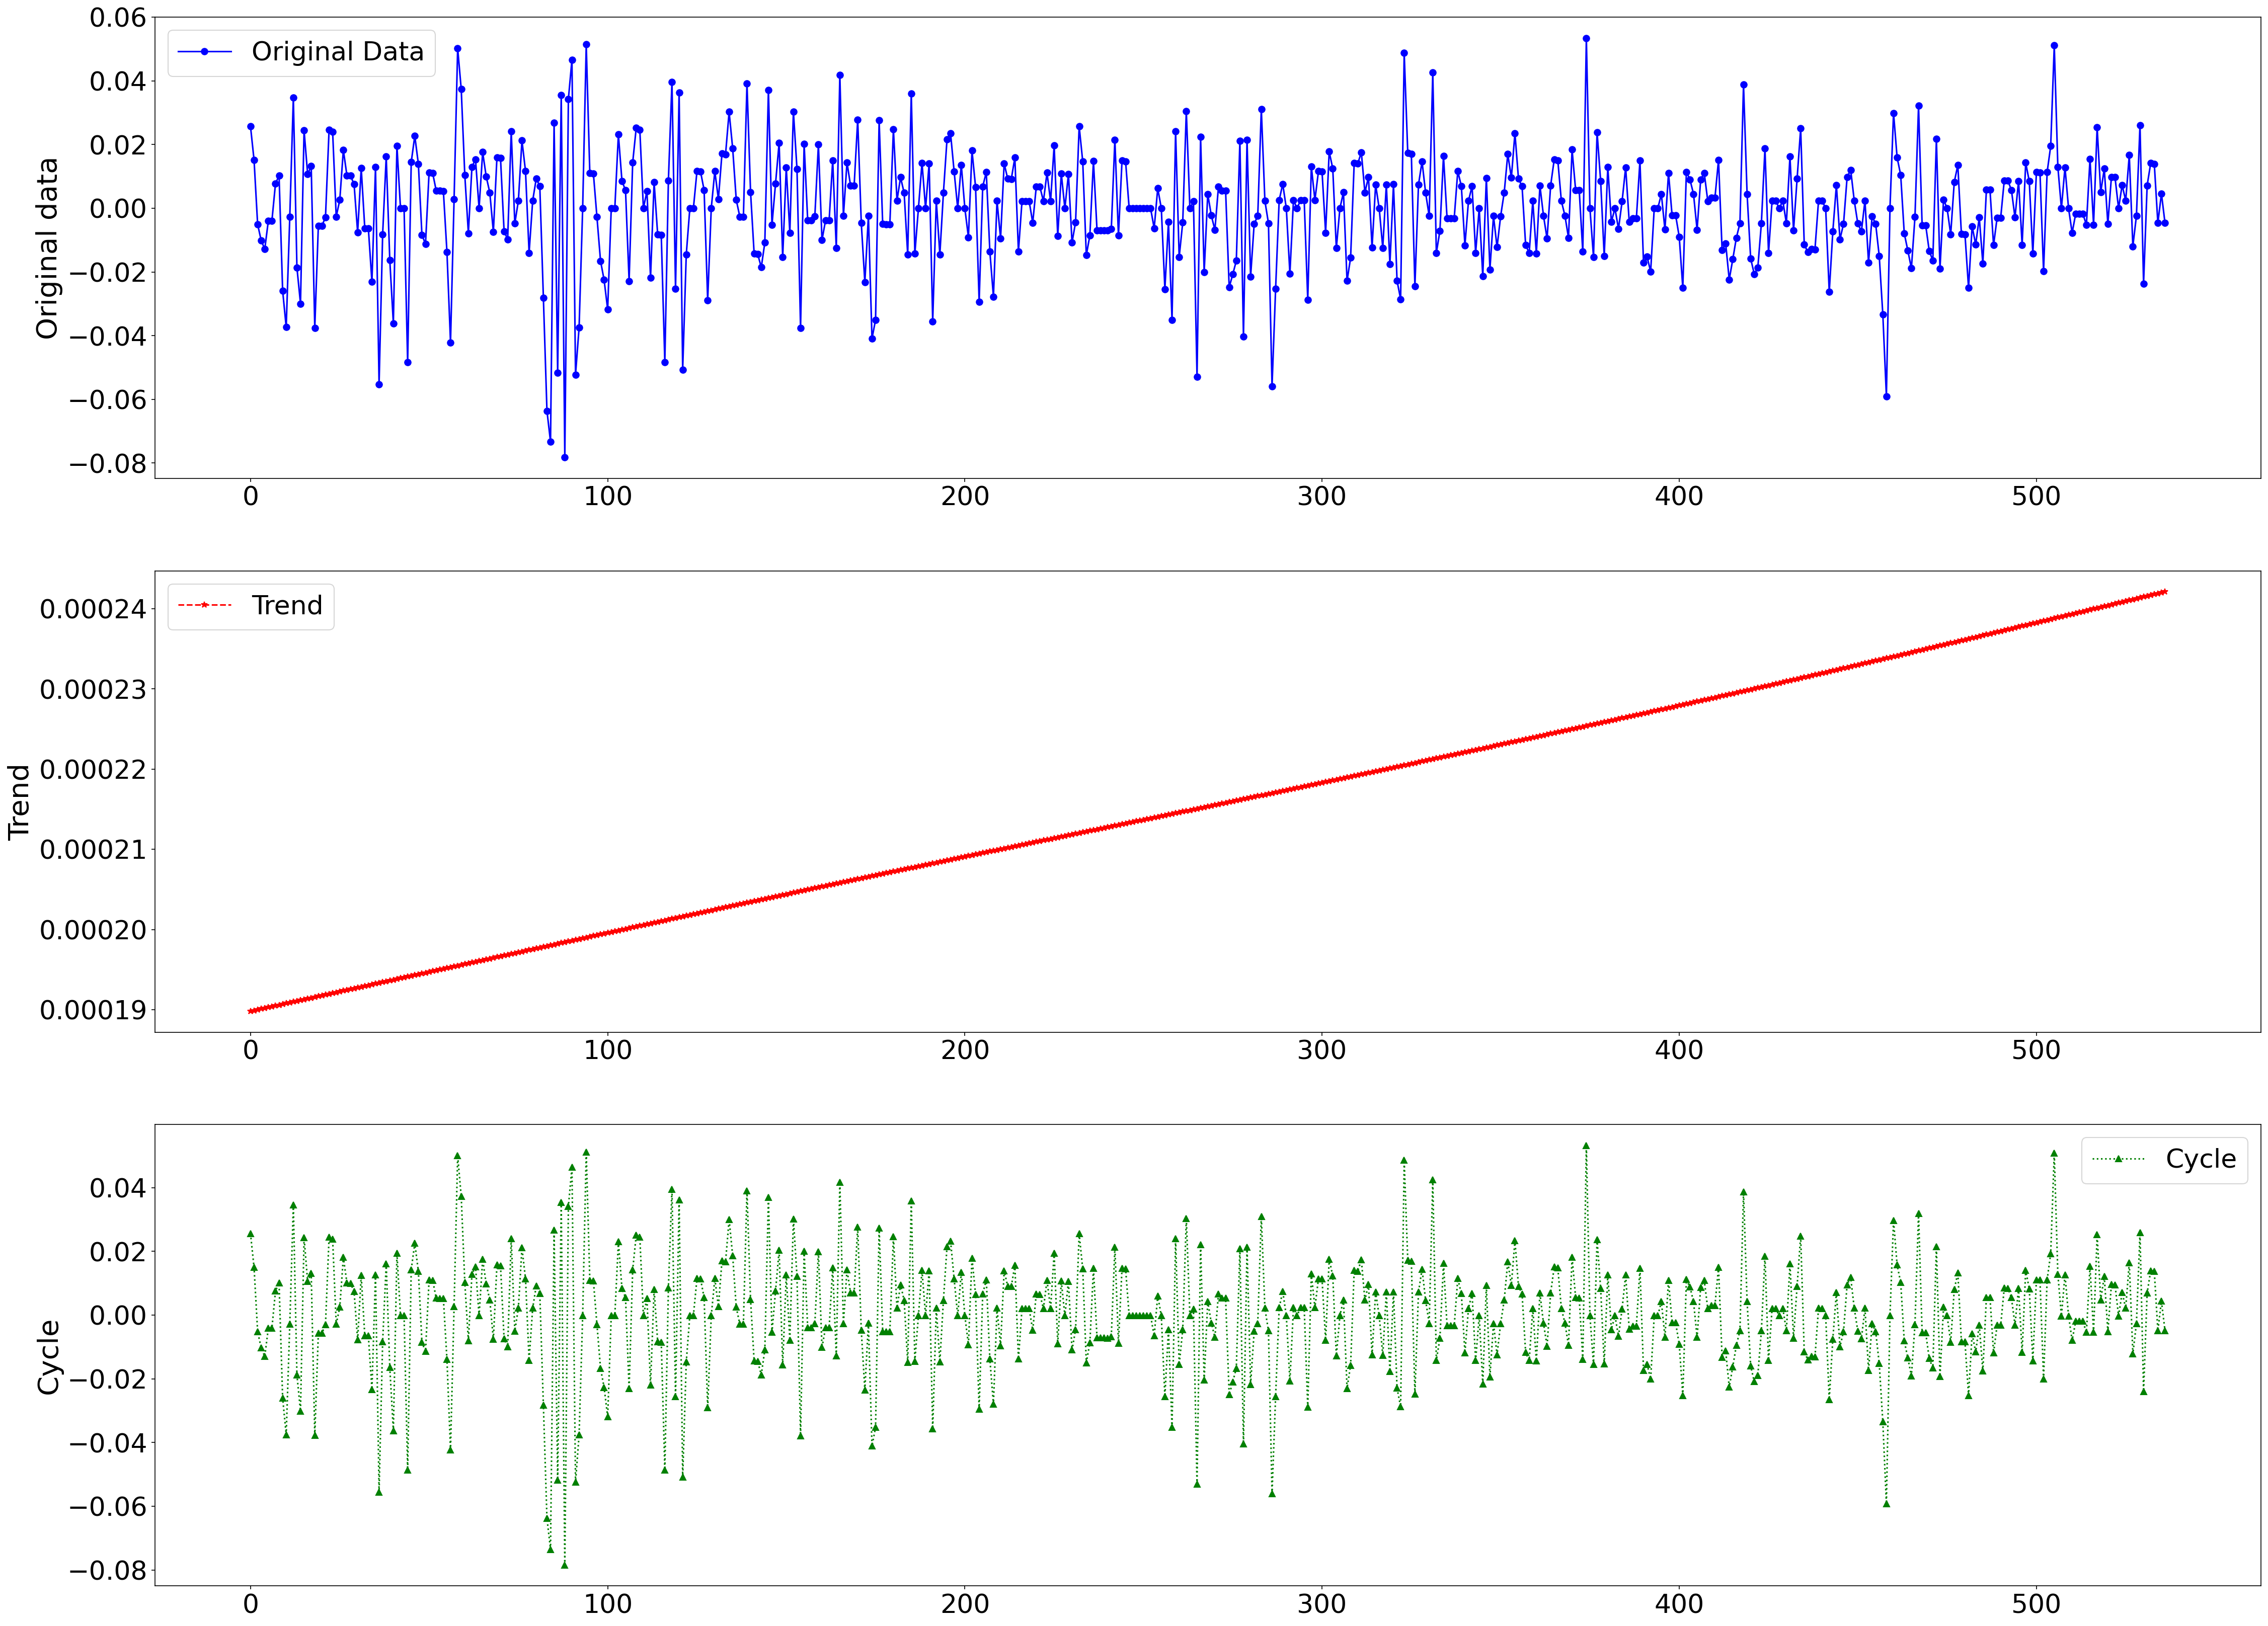

In [13]:
## 数据分解
# 使用hp滤波进行分解并只保留趋势
# Ravn and Uhlig(2002)的建议，对于年度数据lambda参数取值6.25(1600/4^4)，对于季度数据取值1600，对于月度数据取值129600(1600*3^4)
cycle, trend = hpfilter(first_order_diff, lamb=104976000000) 

plt.figure(figsize=(36, 27), dpi=150)
# 绘制原始数据序列图
plt.subplot(3, 1, 1)
plt.plot(first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.legend(fontsize=25)
plt.ylabel('Original data', fontsize=27)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# 绘制趋势项序列图
plt.subplot(3, 1, 2)
plt.plot(trend, linestyle='--', color='r', marker='*', markerfacecolor='r', label='Trend')
plt.legend(fontsize=25)
plt.ylabel('Trend', fontsize=27)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# 绘制周期项序列图
plt.subplot(3, 1, 3)
plt.plot(cycle, linestyle=':', color='g', marker='^', markerfacecolor='g', label='Cycle')
plt.legend(fontsize=25)
plt.ylabel('Cycle', fontsize=27)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig(fname='hp滤波后美国五年国债收益率序列图及分解.png')

## 六、趋势拟合与预测——Holt指数平滑法
观察趋势曲线为线性趋势，采用Holt指数平滑拟合并预测，预测为未来7个数据，事实上经过后面的计算“7”是周期，即预测未来一个周期

预测的未来7个趋势数据点是: 537    0.000242
538    0.000242
539    0.000242
540    0.000243
541    0.000243
542    0.000243
543    0.000243
dtype: float64
95%置信区间下限是: 537    0.000242
538    0.000242
539    0.000242
540    0.000243
541    0.000243
542    0.000243
543    0.000243
dtype: float64
95%置信区间上限是: 537    0.000242
538    0.000242
539    0.000242
540    0.000243
541    0.000243
542    0.000243
543    0.000243
dtype: float64


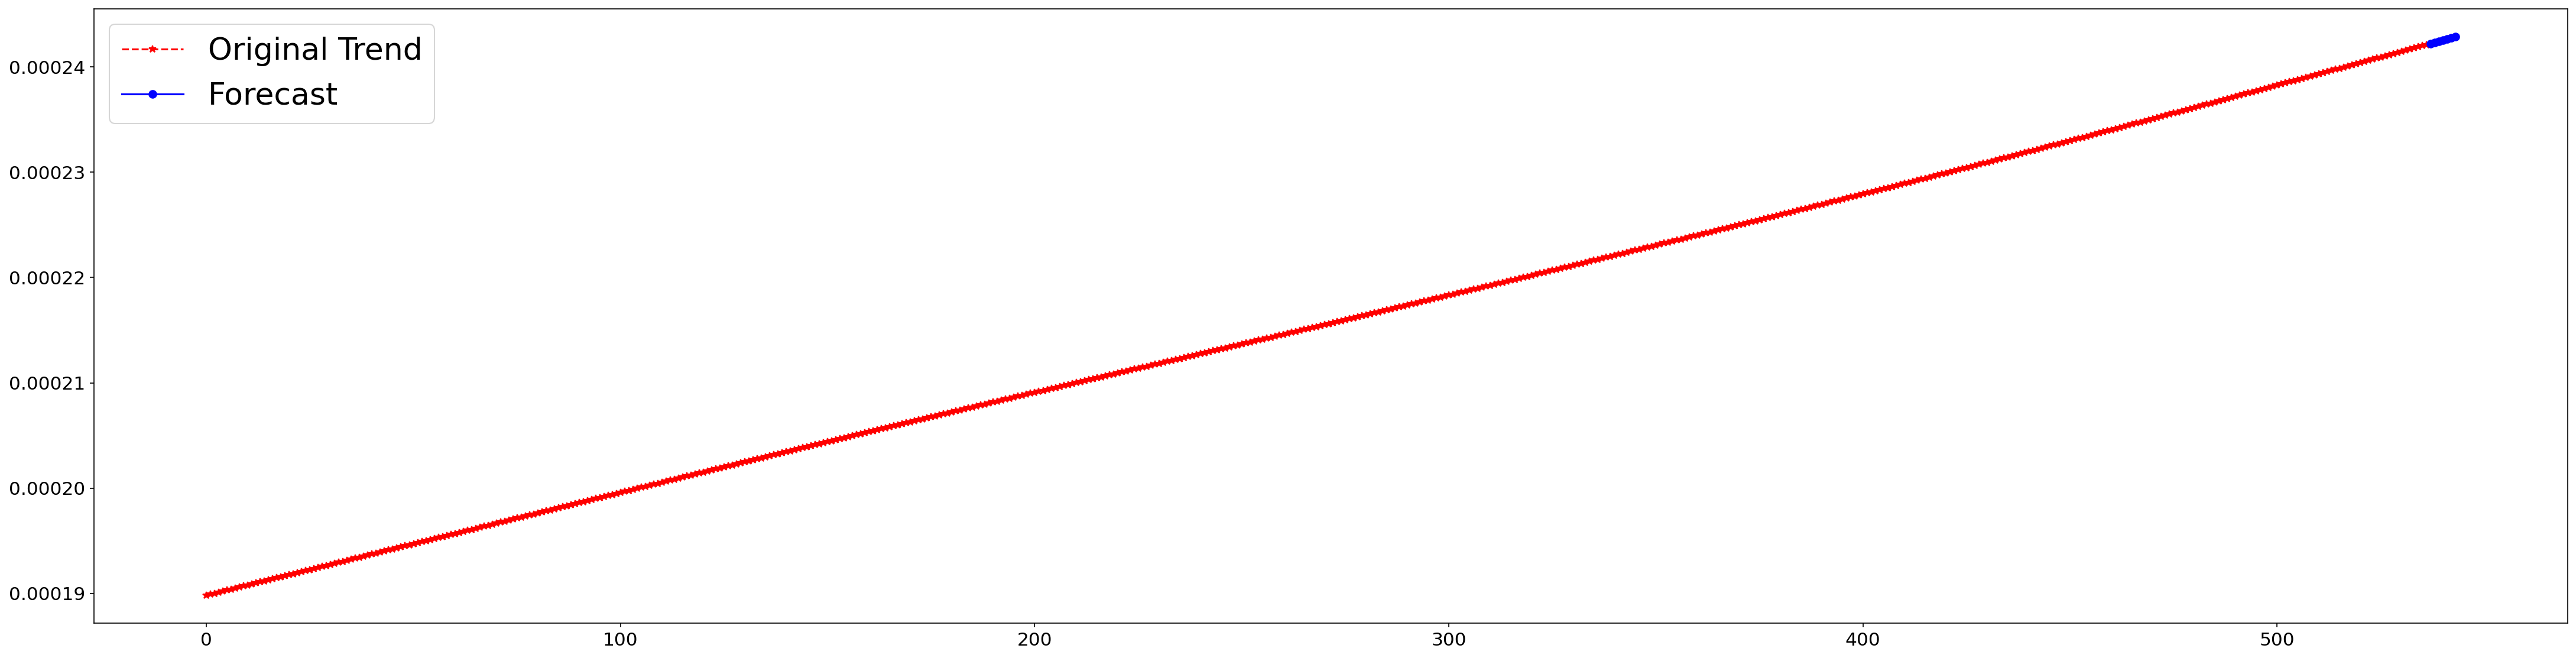

In [18]:
## 趋势拟合，线性趋势采用二次指数平滑法Holt线性趋势方法建模
# 将数据转换为Pandas Series
trend_series = pd.Series(trend)

# 使用Holt线性趋势方法建模
model = ExponentialSmoothing(trend_series, trend="add", seasonal=None, damped_trend=False)
model_fit = model.fit()

# 预测未来7个数据
forecast = model_fit.forecast(7)
print("预测的未来7个趋势数据点是:", forecast)

# 计算置信区间
residuals = model_fit.resid
std_residuals = np.std(residuals)
z_score = 1.96
lower_bound = forecast - z_score * std_residuals
upper_bound = forecast + z_score * std_residuals
print("95%置信区间下限是:", lower_bound)
print("95%置信区间上限是:", upper_bound)

# 绘制原始趋势数据和预测数据在同一图上
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(trend, linestyle='--', color='r', marker='*', markerfacecolor='r', label='Original Trend')
forecast_index = pd.RangeIndex(start=len(trend), stop=len(trend) + 7)
forecast_series = pd.Series(forecast, index=forecast_index)
plt.plot(forecast_series, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Forecast')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=25)
plt.savefig(fname='趋势数据及预测数据序列图.png')

## 七、周期确定与预测——快速傅立叶变换FFT
先对周期数据做快速傅立叶变换（FFT）得到频域数据，通过计算谱密度峰值对应频率，得到周期长度  
本数据得到的周期长度为7天，正好为1周，符合基本情况  
利用最近一周为模版预测未来一周的数据

估计的周期长度为: 7.16
预测的未来7个周期数据点是: [-0.02393927  0.0069269   0.01394294  0.01374444 -0.00488229  0.00439836
 -0.0048825 ]


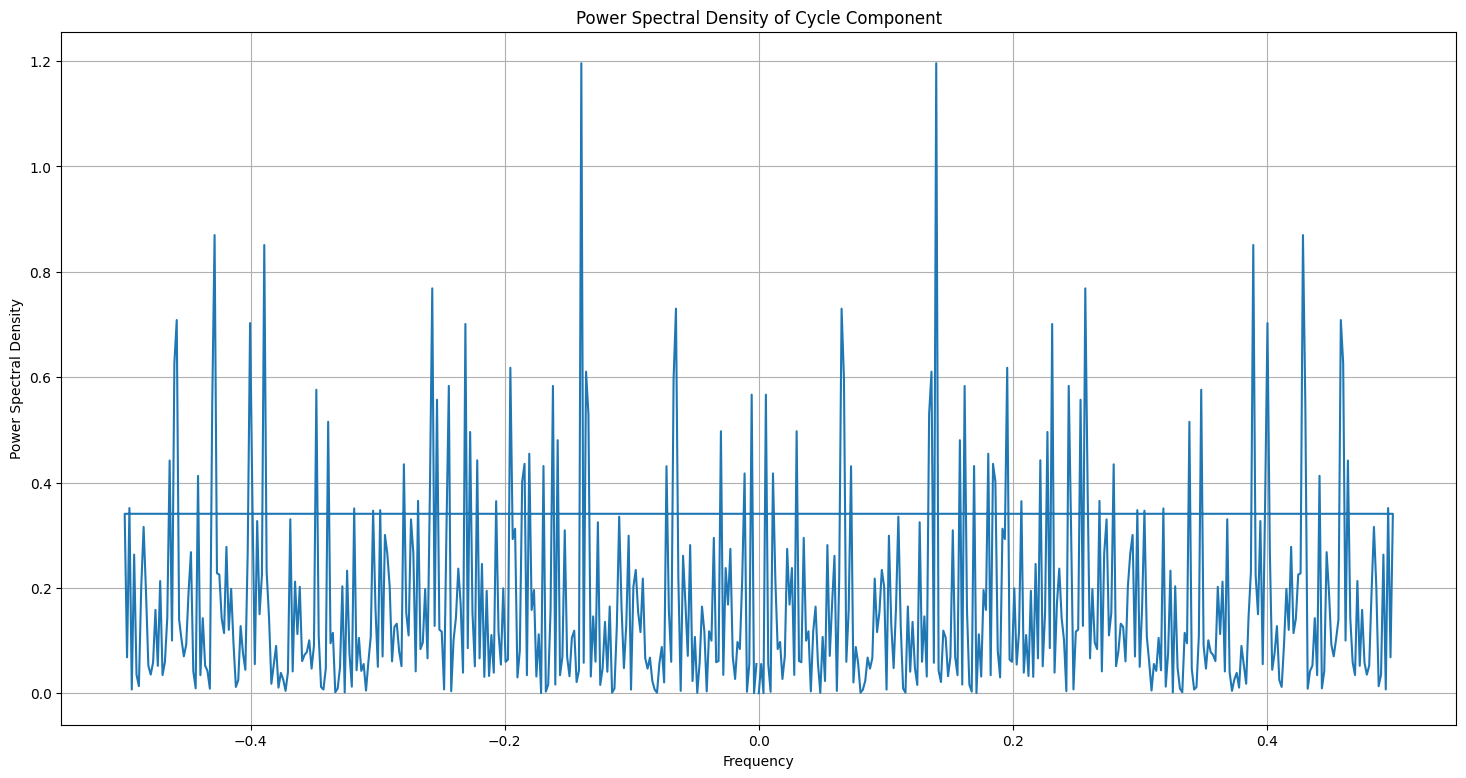

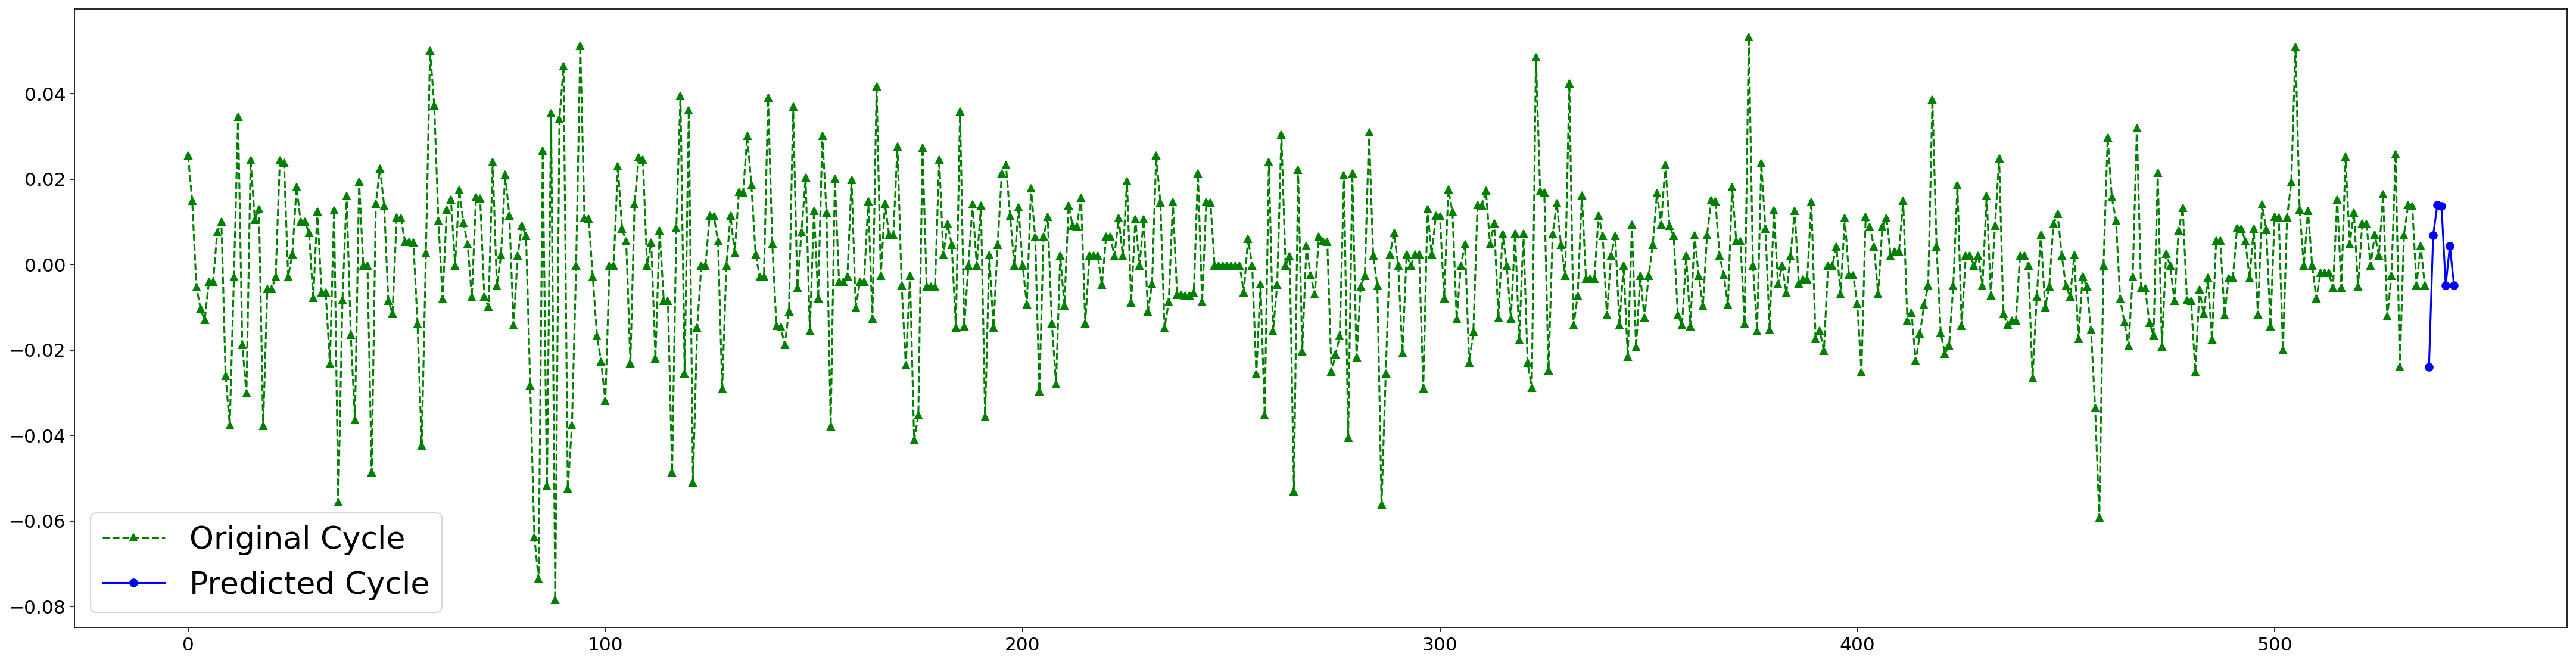

In [19]:
## 周期处理
# 对周期项进行快速傅里叶变换
fft_cycle = np.fft.fft(cycle)
# 获取频率数组
freq = np.fft.fftfreq(len(cycle))

# 计算功率谱密度（幅度的平方）
psd = np.abs(fft_cycle) ** 2

# 绘制功率谱密度图
plt.figure(figsize=(18, 9))
plt.plot(freq, psd)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Cycle Component')
plt.grid(True)
plt.savefig(fname='快速傅立叶变换后的频域数据.png')

# 找到功率谱密度的峰值对应的频率
peak_index = np.argmax(psd)
peak_frequency = freq[peak_index]

# 根据频率计算周期长度
if peak_frequency!= 0:
    period_length = 1 / np.abs(peak_frequency)
    print(f"估计的周期长度为: {period_length}")
else:
    print("未找到明显的周期峰值，无法准确确定周期长度。")

# 找到最近一个完整周期的数据作为模板
last_complete_cycle_start = len(cycle) - int(period_length)
last_complete_cycle = cycle[last_complete_cycle_start:len(cycle)]

# 预测未来1个周期（共7个数据点）
predicted_cycle = np.tile(last_complete_cycle, 1)
print("预测的未来7个周期数据点是:", predicted_cycle)

# 绘制原始周期数据和预测数据在同一图上
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(cycle, linestyle='--', color='g', marker='^', markerfacecolor='g', label='Original Cycle')
prediction_index = pd.RangeIndex(start=len(cycle), stop=len(cycle) + 7)
predicted_cycle_series = pd.Series(predicted_cycle, index=prediction_index)
plt.plot(predicted_cycle_series, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Predicted Cycle')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=25)
plt.savefig(fname='周期数据及预测数据序列图.png')

## 八、数据还原与原始数据预测

预测结果: 537    4.348492
538    4.363956
539    4.394858
540    4.425745
541    4.415449
542    4.425738
543    4.415448
dtype: float64


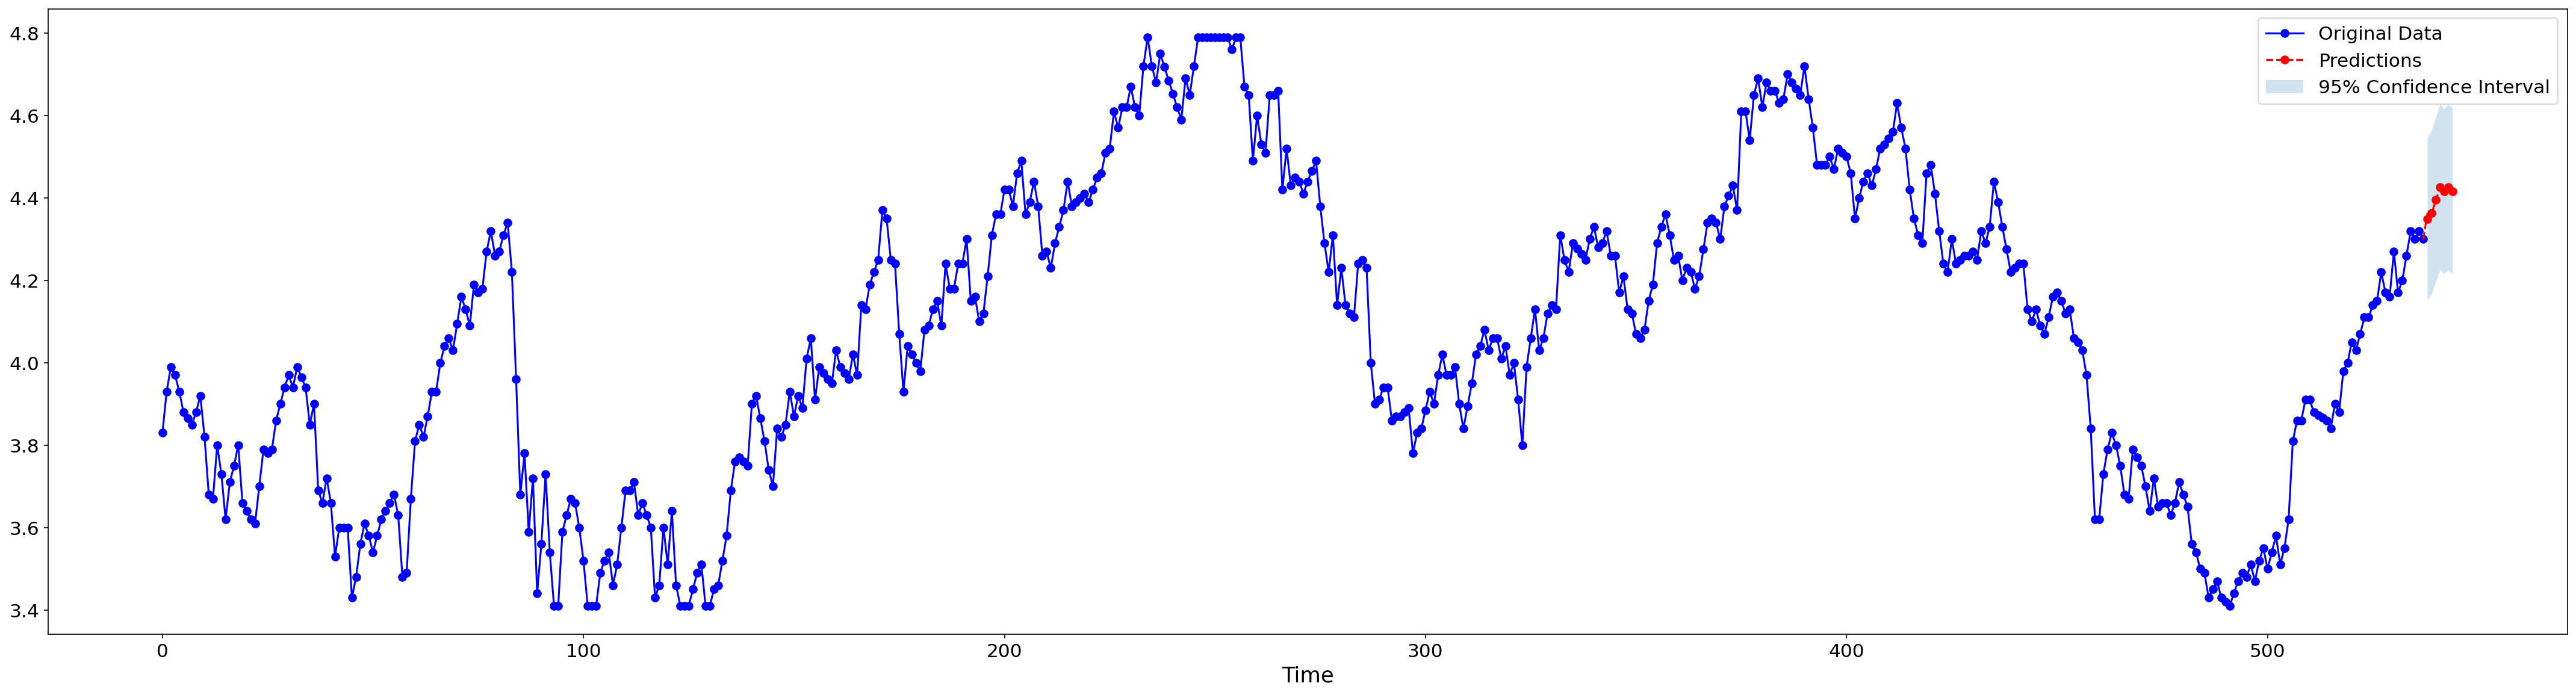

In [20]:
# 趋势还原
reversed_diff_trend = np.cumsum(forecast) 
reversed_log_trend = np.exp(reversed_diff_trend)
# 趋势的置信区间还原
reversed_diff_lower = np.cumsum(lower_bound) 
reversed_log_lower = np.exp(reversed_diff_lower)
reversed_diff_upper = np.cumsum(upper_bound) 
reversed_log_upper = np.exp(reversed_diff_upper)

# 周期还原
reversed_diff_cycle = np.cumsum(predicted_cycle) 
reversed_log_cycle = np.exp(reversed_diff_cycle)

## 组合还原
combined_prediction = 2.2*(reversed_log_trend + reversed_log_cycle)
print("预测结果:", combined_prediction)

data = winsorized_data.flatten()
mean_forecast = combined_prediction
lower = 2.1*(reversed_log_lower + reversed_log_cycle)
upper = 2.3*(reversed_log_upper + reversed_log_cycle)

# 绘图
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(range(len(data)), data, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.plot(range(len(data), len(data) + len(mean_forecast)), mean_forecast, linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(data), len(data) + len(mean_forecast)), lower, upper, alpha=0.2, label='95% Confidence Interval')
last_data_index = len(data) - 1
last_pred_index = len(data)
plt.plot([last_data_index, last_pred_index], [data[last_data_index], mean_forecast[last_data_index + 1]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='预测结果与95%置信区间.png')